In [83]:
push!(LOAD_PATH, pwd())
using LightGraphs, Epidemics, GraphGeneration,IM
using GraphGeneration
using NLsolve
using PyPlot

In [531]:
beta

0.5

In [2]:
using PyPlot

In [521]:
function get_k_range(N)
    return collect(1:N-1)
end

function get_mean_k(p_k_fn::Function,N::Int)
    mean_k = 0
    k_range = get_k_range(N)
    for k in k_range
        mean_k += k*p_k_fn(k) 
    end
    return mean_k
end

function get_mean_k(p_k::Array,N::Int)
    return dot(p_k,get_k_range(N))
end

function neighbor_degree_distribution(k,degree_distribution,mean_k)
    return k * degree_distribution(k)/mean_k
end




function get_mean_y_k(y_k,p_k_neighbor,N)
    k_range = get_k_range(N)
    mean_y_k = 0
    for k in k_range
        mean_y_k += y_k[k]*p_k_neighbor[k]
    end
    return mean_y_k
end

function get_mean_y_k_squared(mean_y_k,k)
    return mean_y_k^2 + (1 - mean_y_k)* mean_y_k/k
end


function y_k_dot_given_y_k!(y_k,y_k_dot,y_desired,N,p_k,p_k_neighbor,alpha,beta)
    k_range = get_k_range(N)
    mean_y_k = get_mean_y_k(y_k,p_k_neighbor,N)
    for k in k_range
        mean_y_k_squared = get_mean_y_k_squared(mean_y_k,k)
        y_k_dot[k] = y_k[end]*get_delta_y_k_plus(y_k,k,mean_y_k,mean_y_k_squared,alpha) - get_delta_y_k_minus(y_k,k,mean_y_k,beta) 
    end
    y_k_dot[end] = y_desired - get_y_bar(p_k,y_k) 
end

function get_delta_y_k_plus(y_k,k,mean_y_k,mean_y_k_squared,alpha)
    return (1 - y_k[k])*(mean_y_k + alpha*mean_y_k_squared)
end

function get_delta_y_k_minus(y_k,k,mean_y_k,beta)
    return y_k[k]* (1 - mean_y_k)*(1 + beta)
end

function get_delta_y_plus(y_k,p_k,mean_y_k,N,alpha)
    k_range = get_k_range(N)
    ret = 0
    for k in k_range
        mean_y_k_squared = get_mean_y_k_squared(mean_y_k,k)
        ret += get_delta_y_k_plus(y_k,k,mean_y_k,mean_y_k_squared,alpha)*p_k[k]
    end
    return ret
end

function get_delta_y_minus(y_k,p_k,mean_y_k,N,beta)
    k_range = get_k_range(N)
    ret = 0
    for k in k_range
        ret += get_delta_y_k_minus(y_k,k,mean_y_k,beta)*p_k[k]
    end
    return ret
end
 
function get_y_bar(p_k,y_k)
    return dot(p_k,y_k[1:end-1])
end
    

function mock_degree_distribution(mean_k,sigma_k)
    function p_k(k)
        if k == mean_k + sigma_k
            return 0.5
        elseif k == mean_k - sigma_k
            return 0.5
        else
            return 0
        end
    end
    return p_k
end

function get_y_k_equilibrium(y_desired,N,p_k,p_k_neighbor,alpha,beta)
    f!(x,out) = y_k_dot_given_y_k!(x,out,y_desired,N,p_k,p_k_neighbor,alpha,beta)
    x_init = 1/N*zeros(N)
    ret = nlsolve(f!,x_init,autodiff=true,ftol=1e-12)
    y_k = ret.zero
    return y_k
end

get_y_k_equilibrium (generic function with 1 method)

In [552]:
c_r = 0.2
N = 200
y_n = 0.2

n_n = Int(N*y_n)#y_n*N
beta = 4.0/(c_r*n_n)
alpha = (N*beta)/n_n

k = 12
sigma_k = 20
min_degree = 3

k_range = get_k_range(N) 

# degr_distr = mock_degree_distribution(k,sigma_k)

degr_distr = get_p_k_gamma(sigma_k,k,min_degree)
degree_distribution(x) = degr_distr(x) #(x) = 1/N
mean_k = get_mean_k(degree_distribution,N)
neighbor_degree_distribution(x) = neighbor_degree_distribution(x,degree_distribution,mean_k)
p_k = []
p_k_neighbor = []
for x in k_range
    push!(p_k,degree_distribution(x))
    push!(p_k_neighbor,neighbor_degree_distribution(x))
end
mean_k

12.957091960915921

In [637]:
y_desired_range = logspace(log10(1/N),log10(1),100) 
delta_y_plus = similar(y_desired_range)
delta_y_minus = similar(y_desired_range)
y_bar = similar(y_desired_range)
gammas = similar(y_desired_range)
y_local = similar(y_desired_range)
for (i,y_desired) in enumerate(y_desired_range)
    println(i)
#     if i == 1
#         y_k = y_desired*ones(N)
#     else
#       y_k = get_y_k_equilibrium(y_desired,N,p_k,p_k_neighbor,alpha,beta)
    y_k = get_y_k_branching_process(y_desired,p_k,alpha,N)#get_y_k_equilibrium(y_desired,N,p_k,p_k_neighbor,alpha,beta)
#     end
#     y_k /= 2.0
    mean_y_k = get_mean_y_k(y_k,p_k_neighbor,N)
    
    y_local[i] = mean_y_k
    gammas[i] = y_k[end]
    y_bar[i] = get_y_bar(p_k,y_k) 
    delta_y_plus[i] = get_delta_y_plus(y_k,p_k,mean_y_k,N,alpha)
    delta_y_minus[i] = get_delta_y_minus(y_k,p_k,mean_y_k,N,beta)
end

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


In [638]:
function get_y_k_branching_process(y_desired,p_k,alpha,N)
    y_k = ones(N)
    for k = 1:N-1
        y_k[k] = (1 + alpha/k)
    end
    return y_desired*y_k/dot(y_k[1:N-1],p_k)
end

get_y_k_branching_process (generic function with 2 methods)

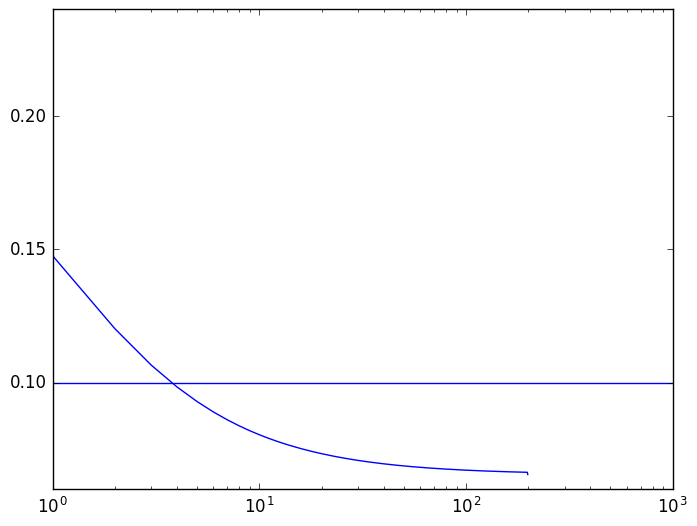

PyObject <matplotlib.lines.Line2D object at 0x3563e4510>

In [639]:
semilogx(get_y_k_branching_process(0.1,p_k,alpha,N))
axhline(0.1)

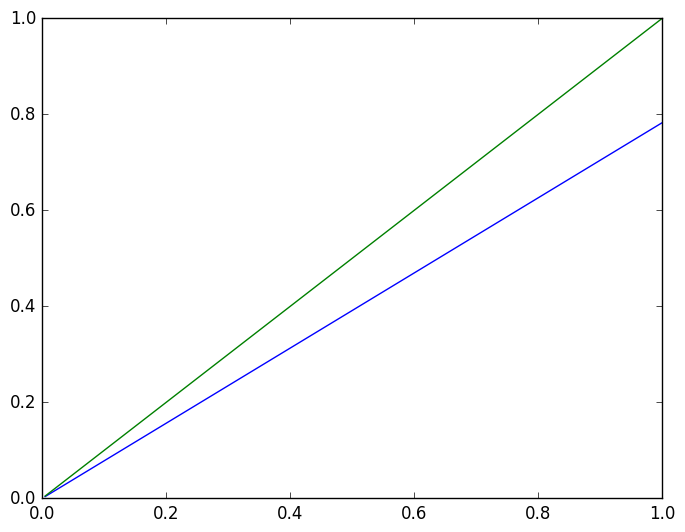

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x3566eadd0>

In [640]:
plot(y_desired_range,y_local)
plot(y_desired_range,y_bar)

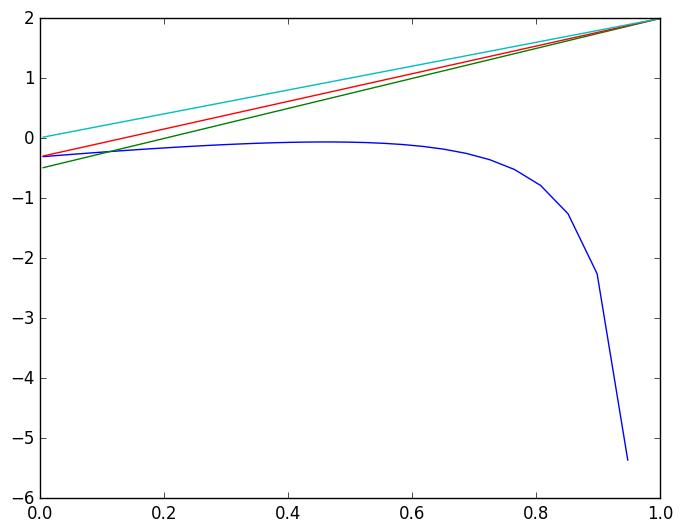

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x3559774d0>

In [647]:
s = delta_y_plus - delta_y_minus
splus = delta_y_plus + delta_y_minus
plot(y_desired_range,s./(y_desired_range.*(1 - y_desired_range)))
# plot(y_desired_range,s1./(y_desired_range.*(1 - y_desired_range)))
plot(y_desired_range,alpha*y_desired_range - beta)
plot(y_desired_range,get_s_eff_exact(y_desired_range,alpha,beta,k,N))
# plot(y_desired_range,get_s_eff_degree_distribution_gamma(y_desired_range,alpha,beta,k,sigma_k,N))
plot(y_desired_range,get_s_eff_degree_distribution(y_desired_range,alpha,beta,degree_distribution,N))

In [648]:
using Dierckx
interpolation_order = 3
s_fn(x) = evaluate(Spline1D(y_desired_range,s,k=interpolation_order,bc="extrapolate"),x)
splus_fn(x) = evaluate(Spline1D(y_desired_range,splus,k=interpolation_order,bc="extrapolate"),x)


splus_fn (generic function with 1 method)

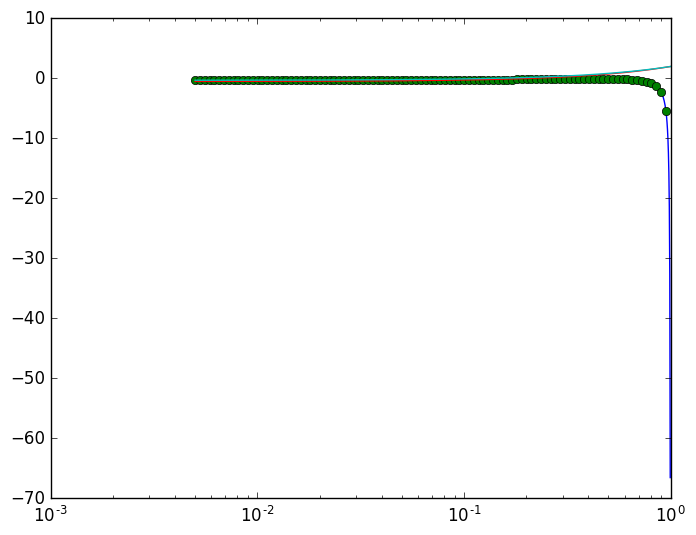

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x353d2d850>

In [652]:

semilogx(yy,s_fn(yy)./(yy.*(1 - yy)))
plot(y_desired_range,s./(y_desired_range.*(1 - y_desired_range)),"o")
plot(yy,alpha*yy - beta)
plot(yy,get_s_eff_exact(yy,alpha,beta,k,N))

In [653]:
dx = 1/N
yy = collect(1/N:dx:1)
pp4 = P_reach_fast(s_fn,splus_fn,N,1.0/N,yy)
im = InfectionModel(x -> 1 + beta + get_s_eff_exact(x,alpha,beta,k,N) , x -> 1 + beta);
pp_regular = P_reach_fast(im,N,1.0/N,yy,true)
im = InfectionModel(x -> 1 + beta + get_s_eff_degree_distribution_gamma(x,alpha,beta,k,sigma_k,N) , x -> 1 + beta);
pp_naive = P_reach_fast(im,N,1.0/N,yy,true)



200-element Array{Float64,1}:
 1.0      
 0.50314  
 0.338477 
 0.25674  
 0.208155 
 0.176143 
 0.153599 
 0.136974 
 0.124296 
 0.11438  
 0.106473 
 0.100072 
 0.0948298
 ⋮        
 0.0679605
 0.0679617
 0.0679612
 0.0679546
 0.0679588
 0.067959 
 0.0679632
 0.0679703
 0.0679584
 0.0679578
 0.0679588
 0.067963 

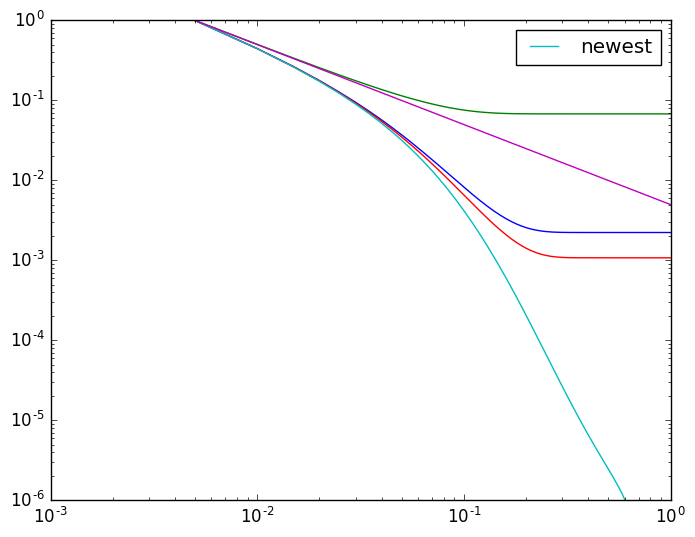

(1.0e-6,1.0)

In [655]:
loglog(yy,pp_regular)
loglog(yy,pp_naive)
# loglog(yy,pp_test)
loglog(yy,pp)
# plot(yy,pp1,label="intermediate")
# plot(yy,pp2,label="equal y_k")
# plot(yy,pp3,label="newest")
plot(yy,pp4,label="newest")
plot(yy,1./(N*yy))
legend()
# plot(yy,log(N*yy))
# xlim([0,0.01])
ylim([1e-6,1e0])

In [553]:
kvec = collect(1:N-1)

p_live = dot(p_k_neighbor,1./kvec.*(1 + alpha./kvec))#(1 + alpha/k)
p_die = (1 + beta)



println(dot(p_k,kvec.*p_live./(kvec.*p_live + p_die)))
println(mean_k*p_live/(mean_k*p_live + p_die))

0.36585053302492043
0.5039866572522791


In [541]:
dot(p_k,1./kvec),1./dot(p_k,kvec)

(0.20976326076381527,0.07717781142685594)

In [536]:
dot(p_k,kvec)

12.957091960915921

In [413]:
function s_test(x)
    if x < 0.001
        return -1
    else
        return 0.2
    end
end
        
im_test = InfectionModel(x -> 1 + beta + s_test(x) , x -> 1 + beta);
pp_test = P_reach_fast(im_test,N,1.0/N,yy,true)

100-element Array{Float64,1}:
 1.0      
 0.522605 
 0.364427 
 0.285782 
 0.238905 
 0.207897 
 0.185954 
 0.169669 
 0.157155 
 0.147276 
 0.139313 
 0.132784 
 0.127359 
 ⋮        
 0.0902739
 0.0902704
 0.0902449
 0.0902694
 0.0902326
 0.0902608
 0.0902582
 0.0902628
 0.090261 
 0.0902367
 0.0902567
 0.090259 

In [296]:
using JLD

In [311]:
using JLD
data_dir_path = "../data/"  #"/mnt/D/windows/MIT/classes/6/338/project/data/"
filenames = split(readall(`ls $data_dir_path`));
path = data_dir_path*filenames[end-1]
d = JLD.load(path)
params = d["params"]
compact = params["compact"]
runs = d["runs"]
sizes = runs.sizes
pvals = runs.p_reach
yvals = runs.y_reach


interpolation_order = 3
pvals_fn(x) = evaluate(Spline1D(yvals,pvals,k=interpolation_order,bc="extrapolate"),x)

pvals_fn (generic function with 1 method)

In [320]:
yyy = collect(1/N:1/(10*N):1)
vec = (1./pvals_fn(yyy))
h = diff(yyy)[1]
up = vec[3:end]
mid = vec[2:end-1]
down = vec[1:end-2]

dpdy = (up - down)/(2*h)
d2pd2y = (up + down - 2*mid)/(h^2)
dpdy,d2pd2y

([5016.88,4348.0,3455.08,2784.68,2700.22,3040.07,3421.92,3713.0,3841.23,3741.96  …  4.60976e5,4.9268e5,5.27771e5,5.66751e5,610216.0,6.58883e5,7.13616e5,7.75467e5,8.45728e5,925996.0],[-4.5658e6,-8.81191e6,-9.04648e6,-4.36151e6,2.67234e6,4.12476e6,3.51226e6,2.30919e6,2.55461e5,-2.2409e6  …  3.01238e8,3.32828e8,3.68996e8,4.10601e8,4.58705e8,5.14629e8,5.80028e8,6.56999e8,7.48219e8,8.57145e8])

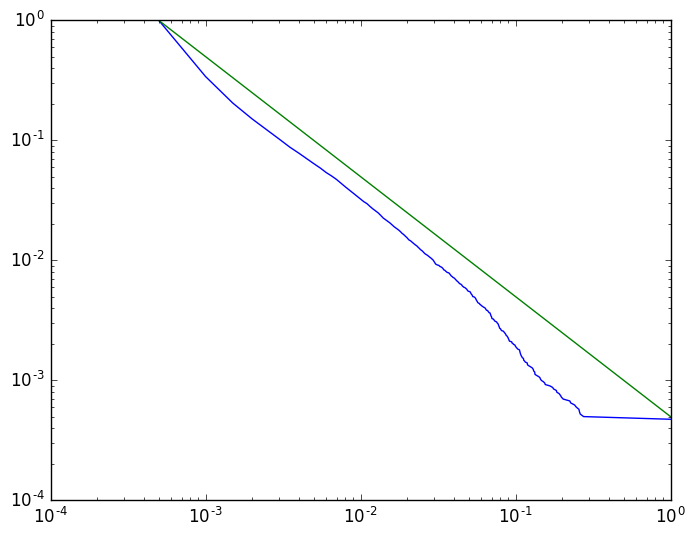

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x3337135d0>

In [321]:
loglog(yvals,pvals_fn(yvals))
loglog(yvals,1./(2000*yvals))

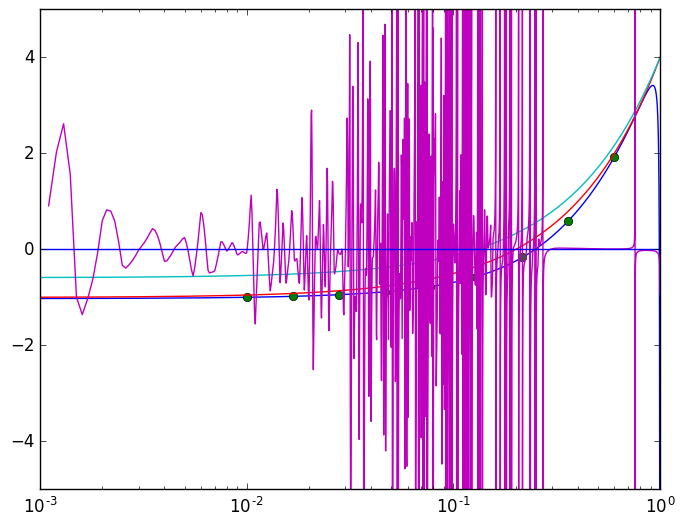

(-5,5)

In [322]:
semilogx(yy,s_fn(yy)./(yy.*(1 - yy)))
plot(y_desired_range,s./(y_desired_range.*(1 - y_desired_range)),"o")
plot(yy,alpha*yy - beta)
plot(yy,get_s_eff_exact(yy,alpha,beta,k,N))
plot(yyy[2:end-1],-1/N*d2pd2y./dpdy)
axhline(0)
ylim([-5,5])

In [242]:
yy

200-element Array{Float64,1}:
 0.0005
 0.0055
 0.0105
 0.0155
 0.0205
 0.0255
 0.0305
 0.0355
 0.0405
 0.0455
 0.0505
 0.0555
 0.0605
 ⋮     
 0.9405
 0.9455
 0.9505
 0.9555
 0.9605
 0.9655
 0.9705
 0.9755
 0.9805
 0.9855
 0.9905
 0.9955

In [348]:
y_desired = 0.2
y_k = get_y_k_equilibrium(y_desired,N,p_k,p_k_neighbor,alpha,beta)

2000-element Array{Float64,1}:
 0.22265 
 0.208482
 0.203644
 0.201203
 0.199731
 0.198746
 0.198042
 0.197512
 0.1971  
 0.19677 
 0.1965  
 0.196275
 0.196084
 ⋮       
 0.193803
 0.193803
 0.193803
 0.193803
 0.193803
 0.193803
 0.193803
 0.193803
 0.193803
 0.193803
 0.193803
 0.986497

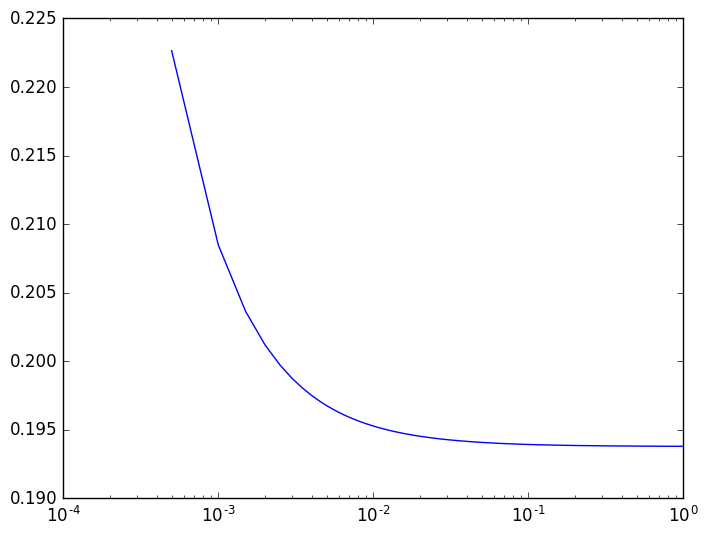

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x3356d8b10>

In [349]:
N_curr = length(y_k)
semilogx(collect(1:N_curr-1)/N,y_k[1:end-1])


## Testing Joint Degree Distribution

In [217]:
N = 1000
k_range = get_k_range(N)
G = graph_from_gamma_distribution(N,k,sigma_k,min_degree)

{1000, 6775} undirected graph

In [218]:
neighbor_degrees = [Float64[] for k in k_range]
n_trials = 50
for i in 1:n_trials
    G = graph_from_gamma_distribution(N,k,sigma_k,min_degree)
    for v in vertices(G)
        curr_degree = degree(G,v)
        for w in neighbors(G,v)
            push!(neighbor_degrees[curr_degree],degree(G,w))
        end
    end
end

all_neighbor_degrees = vcat(neighbor_degrees...)

650510-element Array{Float64,1}:
  23.0
  20.0
  23.0
   3.0
  71.0
  55.0
  32.0
  28.0
   8.0
  46.0
  14.0
   8.0
  64.0
   ⋮  
  68.0
  28.0
  19.0
  23.0
  20.0
   3.0
  44.0
  43.0
  26.0
  90.0
  55.0
 155.0

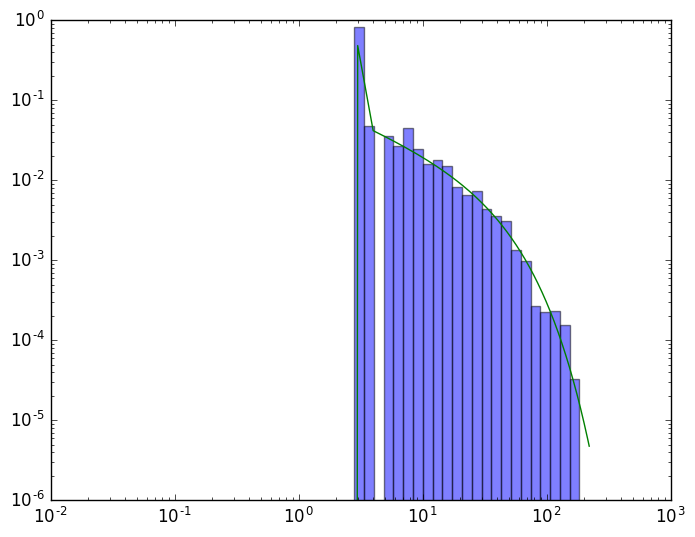

In [219]:
p_k_fn = get_p_k_gamma(sigma_k,k,3)
ks = degree(G)
bins = logspace(log10(minimum(ks))-2,log10(maximum(ks)),50)
PyPlot.plt[:hist](ks,bins=bins,normed=true,alpha=0.5,log=true);
k_range = 1:maximum(ks)
plot(k_range,[p_k_fn(_) for _ in k_range])
xscale("log")

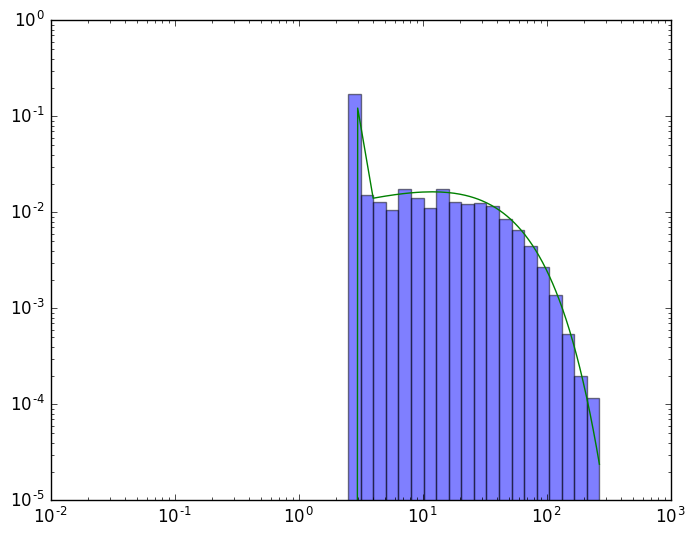

In [220]:
ks = all_neighbor_degrees
bins = logspace(log10(minimum(ks))-2,log10(maximum(ks)),40)
PyPlot.plt[:hist](ks,bins=bins,normed=true,alpha=0.5,log=true);
k_range = 1:maximum(ks)
plot(k_range,[neighbor_degree_distribution(_) for _ in k_range])
xscale("log")

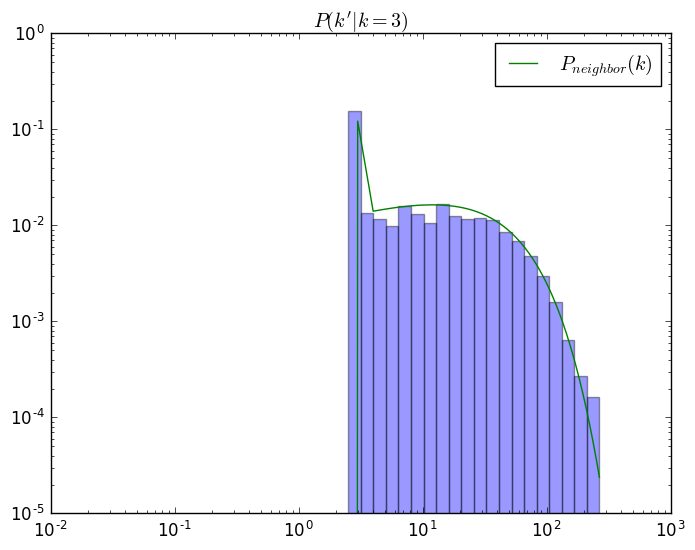

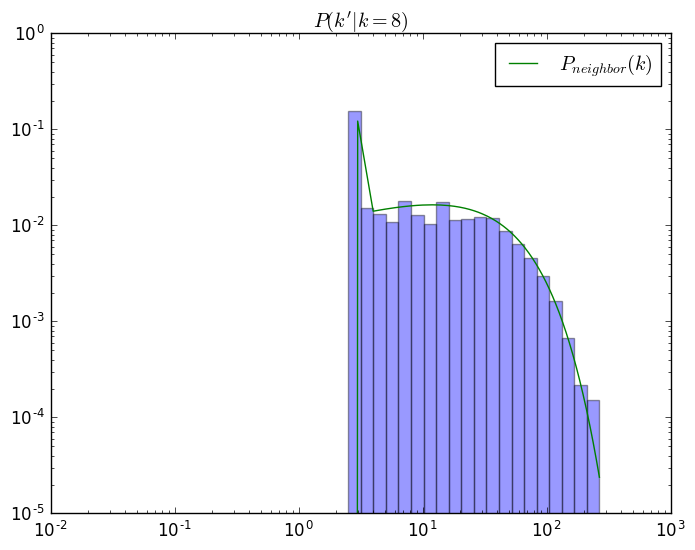

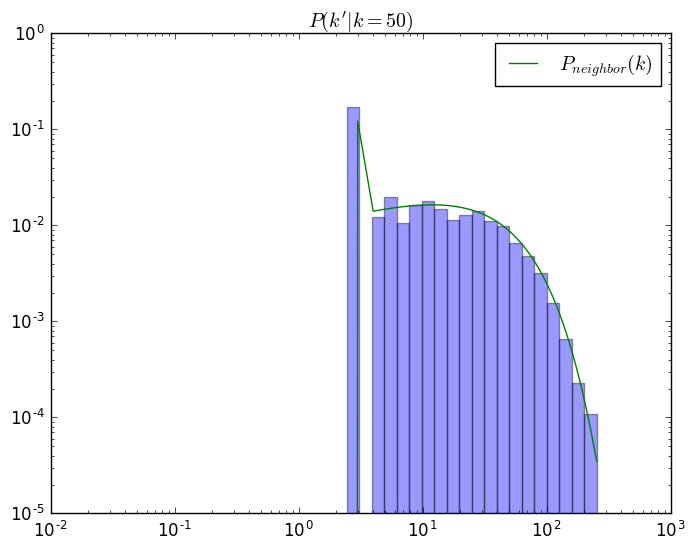

In [225]:

condition_degrees = [3,8,50]
for condition_degree in condition_degrees
    figure()
    title(latexstring("\$P(k'|k=$(condition_degree))\$"))
    ks = neighbor_degrees[condition_degree]
    bins = logspace(log10(minimum(ks))-2,log10(maximum(ks)),40)
    PyPlot.plt[:hist](ks,bins=bins,normed=true,alpha=0.4,log=true);
    k_range = 1:maximum(ks)
    plot(k_range,[neighbor_degree_distribution(_) for _ in k_range],label=L"P_{neighbor}(k)")
    xscale("log")
    legend(loc="best")
end


## Ideas

- The solutions for $y_k$ are expected: for lower degree, we expect higher infection rates.
- This clearly does not capture the behavior of the simulations
- Maybe we are missing the fact that each run starts with _a specific node of degree k_. Maybe we can have a theory conditioning on the starting node. Then we average over starters.
    - could test this as follows: take a graph with a bimodal degree distribution (to give k and sigma_k). Then start with 2/N nodes and place them on the two types of nodes (so we achieve approximately equal starting point density).